# Omics course data analysis 
-------------
version 2019-11-18 (zaro)


In [29]:
#install.packages("openxlsx", dependencies = TRUE)
#install.packages("ggpubr")
#install.packages("factoextra")
#install.packages("pheatmap")
#install.packages('BiocManager')
#BiocManager::install('EnhancedVolcano')
#BiocManager::install('ReactomePA')
#BiocManager::install("clusterProfiler")
#BiocManager::install("org.Hs.eg.db")

In [1]:
library(ggpubr)
library(tidyverse)
library(factoextra)
library(pheatmap)
library(EnhancedVolcano)
library(ReactomePA)
library(clusterProfiler)
library(org.Hs.eg.db)
library(openxlsx)

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: magrittr
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.2  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Loading required package: ggrepel

Registered S3 method overwritten by 'enrichplot':
  method          

# (1) data simulation

In this case we have only one real data set (treatment and control) and simulate the other samples to be able to test some of the basic concepts of omics data analysis.

In [2]:
data.raw <- read.xlsx(xlsxFile="Praktikum_Proteomics_Sysbio.xlsx", sheet = 1, startRow = 1, colNames = TRUE,
  rowNames = FALSE)
head(data.raw)
colnames(data.raw) <- c("protein","ctrl_1","treat_1")
head(data.raw)

Protein.IDs,Control.[Intensity],Treatment.[Intensity]
<chr>,<dbl>,<dbl>
C9J600,75877.0,61317.0
A0A024RBD0,0.0,35093.0
A0A024RDB0,797730.0,732160.0
A0JNW5,9395.7,8861.2
A0MZ66,4336.3,4337.7
A1L0T0,0.0,205780.0


protein,ctrl_1,treat_1
<chr>,<dbl>,<dbl>
C9J600,75877.0,61317.0
A0A024RBD0,0.0,35093.0
A0A024RDB0,797730.0,732160.0
A0JNW5,9395.7,8861.2
A0MZ66,4336.3,4337.7
A1L0T0,0.0,205780.0


In [3]:
set.seed(123)
generate_intensity <- function(x) {rnorm(n=1,mean=x,sd=0.1*x)}
data.raw$ctrl_2 <- sapply(data.raw$ctrl_1,generate_intensity)
data.raw$ctrl_3 <- sapply(data.raw$ctrl_1*2.0,generate_intensity)
data.raw$treat_2 <- sapply(data.raw$treat_1,generate_intensity)
data.raw$treat_3 <- sapply(data.raw$treat_1*0.1,generate_intensity)
data.raw$treat_4 <- data.raw$ctrl_1[sample(1:nrow(data.raw),nrow(data.raw))]
data.raw <- data.raw[,c(1,2,4,5,3,6,7,8)]
head(data.raw)


protein,ctrl_1,ctrl_2,ctrl_3,treat_1,treat_2,treat_3,treat_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C9J600,75877.0,71624.279,151096.187,61317.0,67903.068,6025.5379,27381
A0A024RBD0,0.0,0.000,0.000,35093.0,35422.250,3315.1778,40920
A0A024RDB0,797730.0,779368.051,1514065.942,732160.0,675559.139,66129.8844,319150
A0JNW5,9395.7,10860.216,17244.081,8861.2,9385.117,923.3987,17896
A0MZ66,4336.3,4366.875,9411.381,4337.7,4489.619,427.7487,188020
A1L0T0,0.0,0.000,0.000,205780.0,202948.887,25042.4502,90456


In [5]:
data.raw %>% dplyr::select(protein,ctrl_1,treat_1) %>% write.xlsx(file = "raw_data_set_1.xlsx", row.names = FALSE)
data.raw %>% dplyr::select(protein,ctrl_2,treat_2) %>% write.xlsx(file = "raw_data_set_2.xlsx", row.names = FALSE)
data.raw %>% dplyr::select(protein,ctrl_3,treat_3) %>% write.xlsx(file = "raw_data_set_3.xlsx", row.names = FALSE)
data.raw %>% dplyr::select(protein,treat_4) %>% write.xlsx(file = "raw_data_set_4.xlsx", row.names = FALSE)

Note: zip::zip() is deprecated, please use zip::zipr() instead


# (2) data preparation

We are going to load either real data sets or the provided simulated data sets and merge them into on data matrix.

In [6]:
data.set1 <- read.xlsx(xlsxFile="raw_data_set_1.xlsx")
data.set2 <- read.xlsx(xlsxFile="raw_data_set_2.xlsx")
data.set3 <- read.xlsx(xlsxFile="raw_data_set_3.xlsx")
data.set4 <- read.xlsx(xlsxFile="raw_data_set_4.xlsx")

data.raw <- left_join(data.set1,data.set2)
data.raw <- left_join(data.raw,data.set3)
data.raw <- left_join(data.raw,data.set4)

data.raw <- data.raw[,c(1,2,4,6,3,5,7,8)]
head(data.raw)

Joining, by = "protein"
Joining, by = "protein"
Joining, by = "protein"


protein,ctrl_1,ctrl_2,ctrl_3,treat_1,treat_2,treat_3,treat_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C9J600,75877.0,71624.279,151096.187,61317.0,67903.068,6025.5379,27381
A0A024RBD0,0.0,0.000,0.000,35093.0,35422.250,3315.1778,40920
A0A024RDB0,797730.0,779368.051,1514065.942,732160.0,675559.139,66129.8844,319150
A0JNW5,9395.7,10860.216,17244.081,8861.2,9385.117,923.3987,17896
A0MZ66,4336.3,4366.875,9411.381,4337.7,4489.619,427.7487,188020
A1L0T0,0.0,0.000,0.000,205780.0,202948.887,25042.4502,90456


It is always advisable to run some basic visual inspections of the provided data, therefore we plot the data in a boxplot and a density plot.

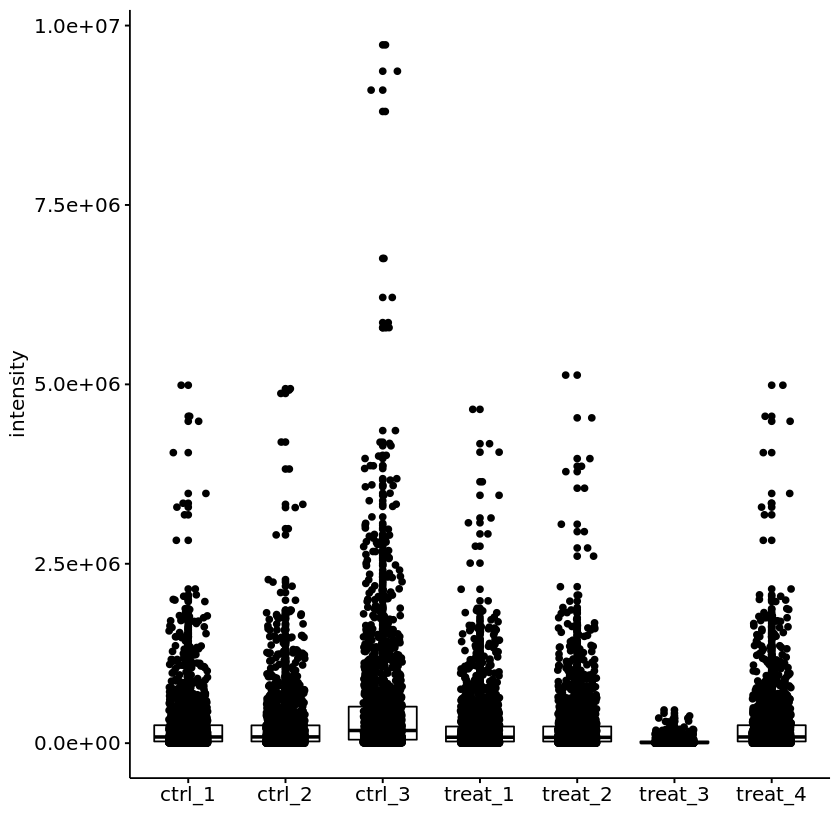

In [7]:
ggboxplot(gather(data.raw,colnames(data.raw)[2:ncol(data.raw)],key="sample",value="intensity"), 
          x = "sample", y="intensity", xlab="",
         palette = get_palette(palette = "npg", 6),
         add = "jitter")

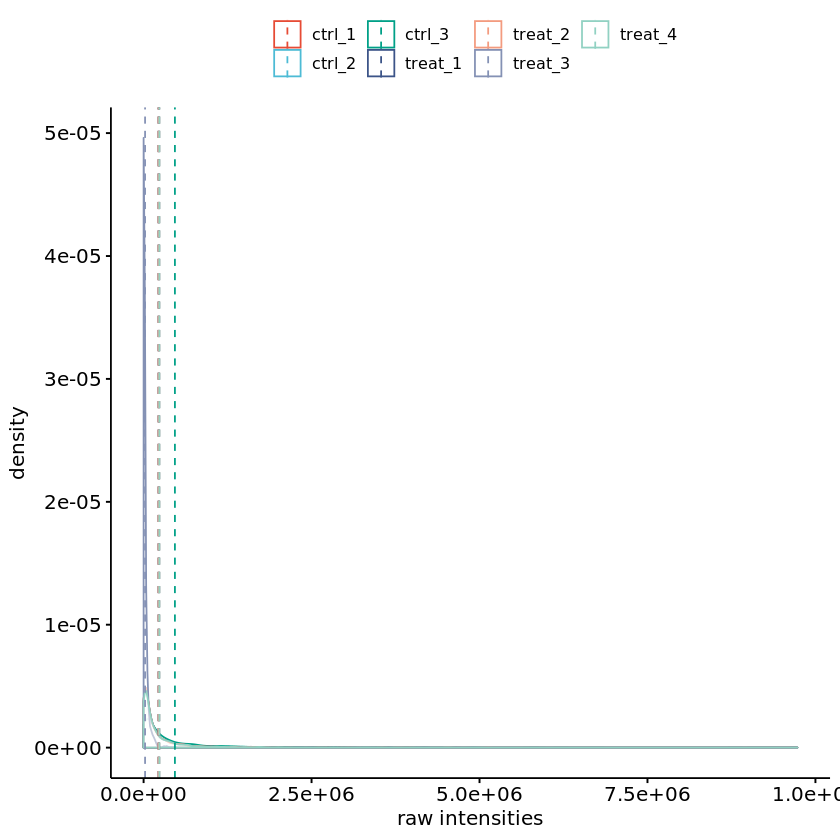

In [8]:
ggdensity(data.raw, x = colnames(data.raw)[2:ncol(data.raw)],
   add = "mean", merge=TRUE, xlab="raw intensities",
   palette = get_palette(palette = "npg", 7))

# (3) data pre-processing

As samples "treat_3" and "ctrl_3" appear shifted in the boxplot we can apply a **normalization** step by substracting the median of intensities from each sample and therefore reduce system biases.
  $$intensity_{normalized}=intensity_{i,n} \cdot \frac{\frac{1}{N}\sum{median(intensities_{n})}}{median(intensities_{n})}$$  
There is wide variety of normalization strategies, some of them summarized in [Tommi Välikangas *et.al.*;2018](https://academic.oup.com/bib/article/19/1/1/2562889).

In [9]:
data.norm <- data.raw
mean.medians <- mean(apply(data.norm[,2:ncol(data.norm)],2,median))
norm.factors <- mean.medians/apply(data.norm[,2:ncol(data.norm)],2,median)
round(norm.factors,1)
data.norm[,2:ncol(data.norm)] <- sweep(data.norm[,2:ncol(data.norm)], 2, norm.factors, "*")

ctrl_1  ctrl_2  ctrl_3 treat_1 treat_2 treat_3 treat_4 
    1.0     1.0     0.5     1.1     1.1    10.8     1.0

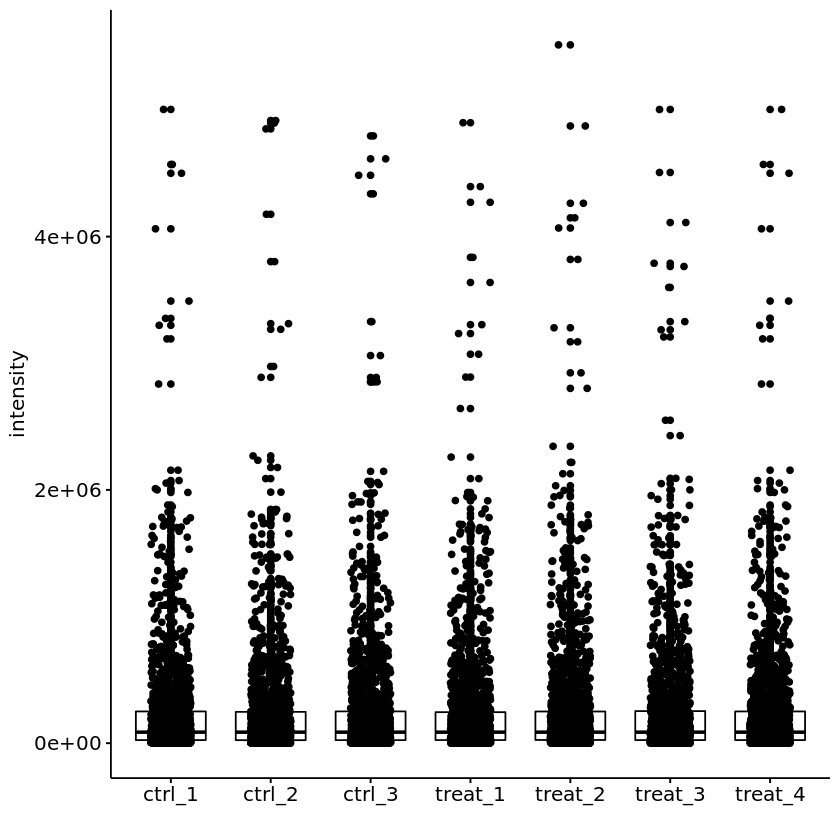

In [10]:
ggboxplot(gather(data.norm,colnames(data.norm)[2:ncol(data.norm)],key="sample",value="intensity"), 
          x = "sample", y="intensity", xlab="", 
         palette = get_palette(palette = "npg", 6),
         add = "jitter")

A **log2 transformation** of the data should
reshape the distribution to a more "normal" like.

In [11]:
data.trans <- data.norm
data.trans[,2:ncol(data.trans)] <- log2(data.norm[,2:ncol(data.norm)])

Warning message:
“Removed 224 rows containing non-finite values (stat_density).”

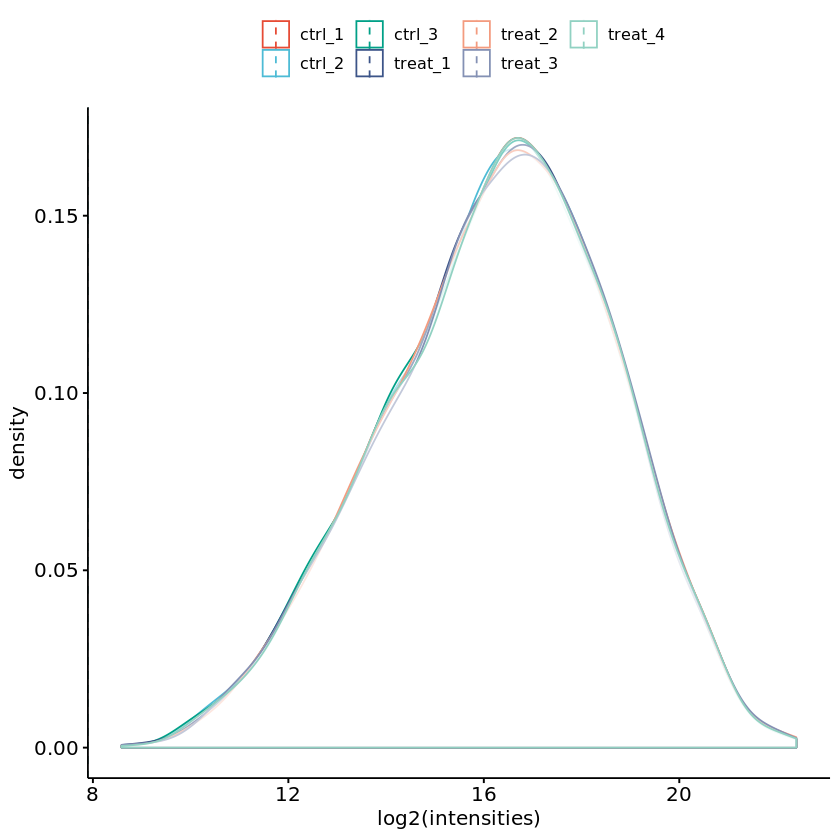

In [12]:
ggdensity(data.trans, x = colnames(data.trans)[2:ncol(data.trans)],
   add = "mean", merge=TRUE, xlab="log2(intensities)", 
   palette = get_palette(palette = "npg", 7))

As we get a warning of removed values, we have to rethink the way we want to deal with "0" intensity values, as they cause troubles during log2 transformation.  We will **impute missing values** ("0" intensities) by replacing them with half of the minimum values measured.

In [13]:
dat.matrix <- data.norm[,2:ncol(data.norm)]
head(dat.matrix)
dat.matrix[is.na(dat.matrix)] <- 0.0
dat.matrix[dat.matrix==0] <- min(dat.matrix[dat.matrix!=0])
head(dat.matrix)
data.trans[,2:ncol(data.trans)] <- log2(dat.matrix)

ctrl_1,ctrl_2,ctrl_3,treat_1,treat_2,treat_3,treat_4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76118.741,71286.896,74452.982,64577.545,73000.046,65131.550,27468.23
0.000,0.000,0.000,36959.078,38081.135,35834.588,41050.37
800271.530,775696.871,746059.362,771092.768,726268.337,714814.505,320166.80
9425.634,10809.059,8497.059,9332.396,10089.588,9981.248,17953.02
4350.115,4346.305,4637.479,4568.358,4826.621,4623.643,188619.02
0.000,0.000,0.000,216722.396,218182.750,270690.124,90744.19


ctrl_1,ctrl_2,ctrl_3,treat_1,treat_2,treat_3,treat_4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76118.7405,71286.8958,74452.9821,64577.545,73000.046,65131.550,27468.23
384.8642,384.8642,384.8642,36959.078,38081.135,35834.588,41050.37
800271.5299,775696.8708,746059.3619,771092.768,726268.337,714814.505,320166.80
9425.6343,10809.0590,8497.0594,9332.396,10089.588,9981.248,17953.02
4350.1152,4346.3046,4637.4789,4568.358,4826.621,4623.643,188619.02
384.8642,384.8642,384.8642,216722.396,218182.750,270690.124,90744.19


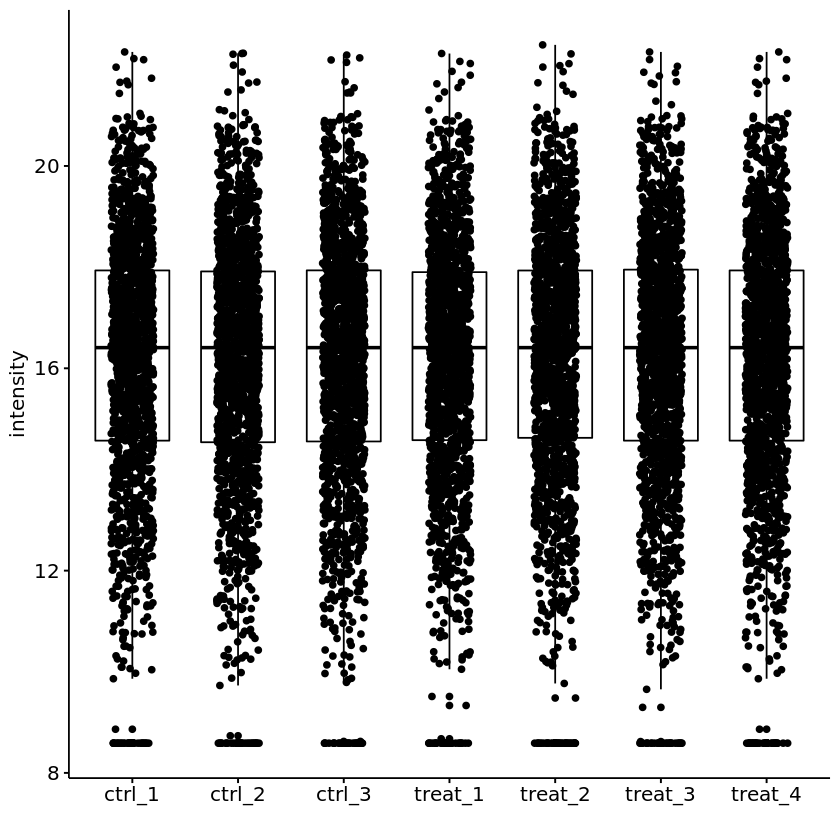

In [14]:
ggboxplot(gather(data.trans,colnames(data.trans)[2:ncol(data.trans)],key="sample",value="intensity"), 
          x = "sample", y="intensity", xlab="",
         palette = get_palette(palette = "npg", 6),
         add = "jitter")

# (4) exploratory data analysis

## (4.1) Filtering

In [15]:
stddev <- apply(data.trans[,2:ncol(data.trans)],1,sd)
means <- rowMeans(data.trans[,2:ncol(data.trans)])
CV <- stddev/means

data <- data.trans[CV>0.2,]
head(CV)
nrow(data.trans)
nrow(data)

[1] 0.03286458 0.28616212 0.02435601 0.02654411 0.15718875 0.34992363

[1] 1610

[1] 102

## (4.2) Principal component analysis (PCA)

PCA is commonly used as data exploratory tool in quality assessement to detect potential outlier samples or in feature selection. Introductory info about PCA can be found in the article by [Ringner;2008](http://www.marcottelab.org/users/BCH339N_2016/NBT_primer_PCA.pdf).

In [16]:
data.mat <- as.matrix(data[,2:ncol(data)])
rownames(data.mat) <- data$protein
head(data.mat)

,ctrl_1,ctrl_2,ctrl_3,treat_1,treat_2,treat_3,treat_4
A0A024RBD0,8.588206,8.588206,8.588206,15.17364,15.21679,15.12907,15.32511
A1L0T0,8.588206,8.588206,8.588206,17.72549,17.73518,18.04628,16.46952
A3KMH1,8.588206,8.588206,8.588206,15.56569,15.44350,15.56131,15.03689
A4D1E9,8.588206,8.588206,8.588206,15.50882,15.48987,15.62746,17.05985
C9K0K2,8.588206,8.588206,8.588206,15.48308,15.48068,15.53223,11.69751
A8CG34,8.588206,8.588206,8.588206,16.49485,16.59967,16.37547,14.32080


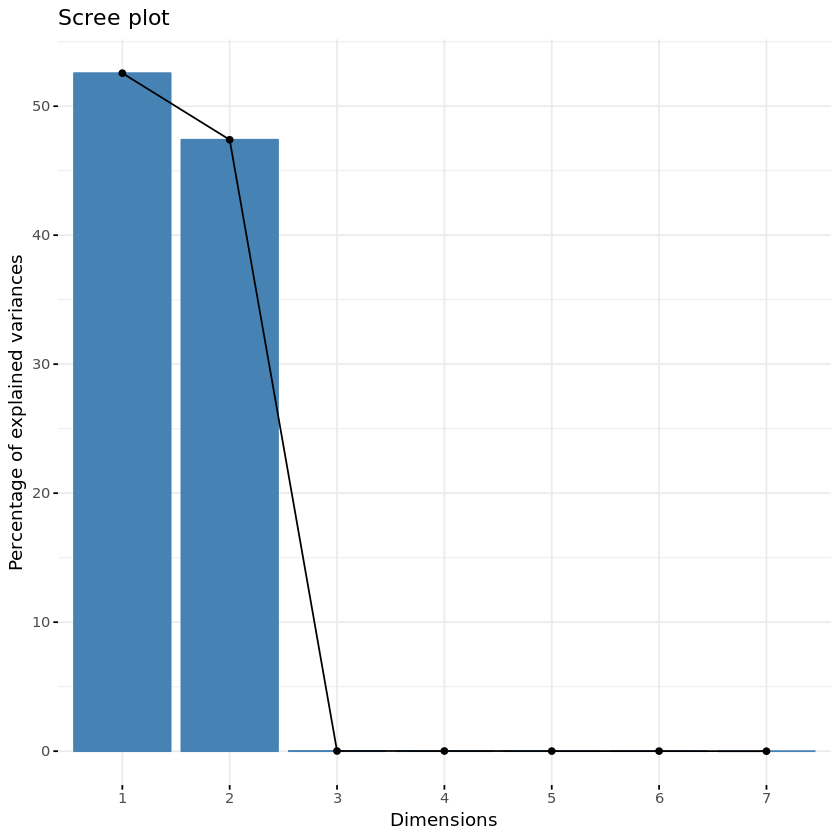

In [17]:
pca <- prcomp(t(data.mat),scale=TRUE)
fviz_eig(pca)

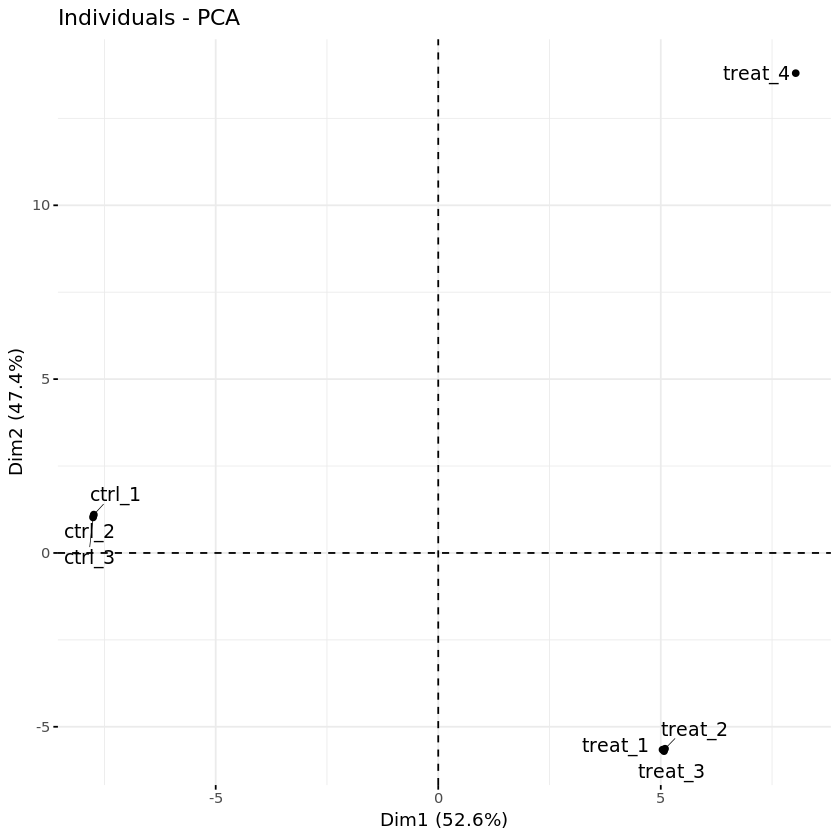

In [18]:
fviz_pca_ind(pca, repel = TRUE)

## (4.3) Agglomerative clustered heatmap

We perform an **unsupervised** learning approach by **hierarchical average clustering** the samples according to their **euclidean distances** in protein expression. For more detailed info about clustering see [Shannon *et.al*;2003](https://www.ncbi.nlm.nih.gov/pubmed/12517285)

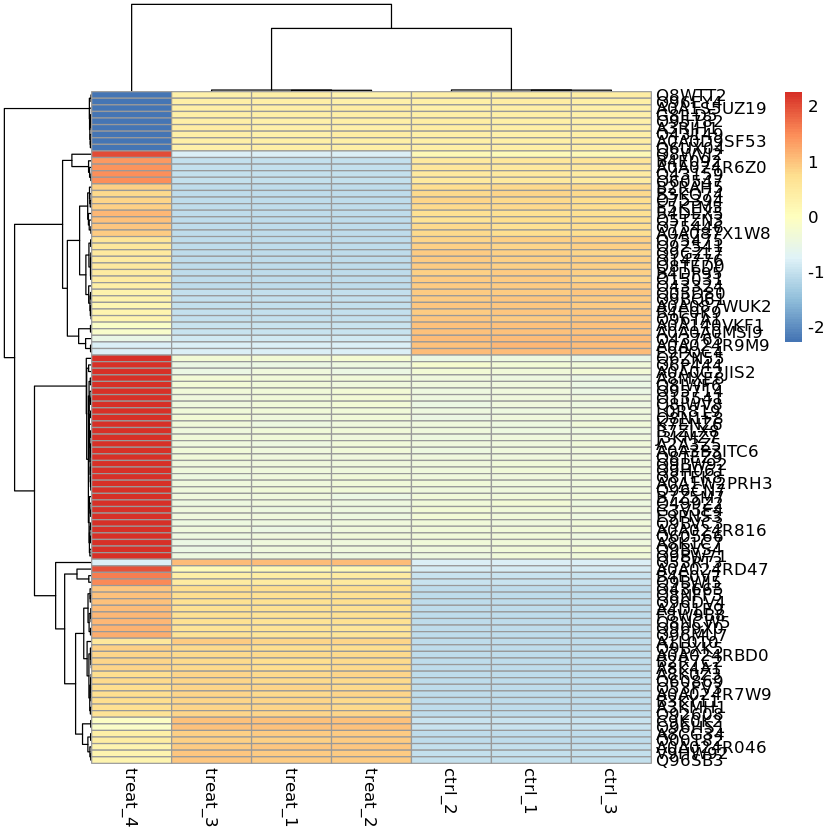

In [19]:
pheatmap(data.mat, scale="row",clustering_distance_cols = "euclidean", clustering_method = "average")

## (4.4) Differential expression analysis

In [20]:
data.mat <- as.matrix(data.trans[,2:(ncol(data.trans)-1)])
rownames(data.mat) <- data.trans$protein

calc.pval <- function(int){(t.test(x=int[1:3],y=int[4:6]))[["p.value"]]}
calc.FC <- function(int){mean(int[4:6])-mean(int[1:3])}

data <- data.frame(protein=data.trans$protein,
                   logFC=apply(data.mat,1,calc.FC),
                   pval=apply(data.mat,1,calc.pval))
head(data)

,protein,logFC,pval
,<fct>,<dbl>,<dbl>
C9J600,C9J600,-0.13197723,1.320371e-01
A0A024RBD0,A0A024RBD0,6.58495933,1.479024e-05
A0A024RDB0,A0A024RDB0,-0.07009899,1.901075e-01
A0JNW5,A0JNW5,0.03951361,7.400306e-01
A0MZ66,A0MZ66,0.07251185,1.426198e-01
A1L0T0,A1L0T0,9.24744394,1.297691e-04


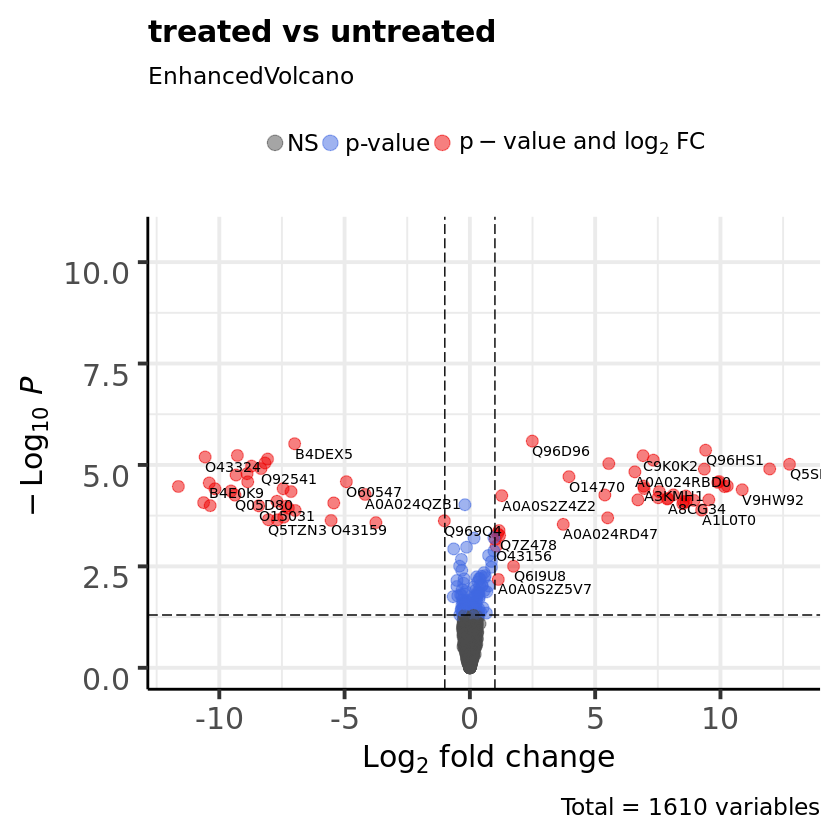

In [21]:
EnhancedVolcano(data,
    title = 'treated vs untreated',
    lab = data$protein,
    x = 'logFC',
    y = 'pval',
    pCutoff = 0.05,
    FCcutoff = 1.0,
    pointSize = 3.0,
    labSize = 3.0)

## (4.5) Multiple testing problem

As we are running many statistical tests on our dataset, we have to expect an inflation of false positives. Therefore we correct the p-values for multiple testing and determine the **false discovery rate** (FDR). More details see [Storey & Tibshirani; 2003](https://www.ncbi.nlm.nih.gov/pubmed/12883005)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”

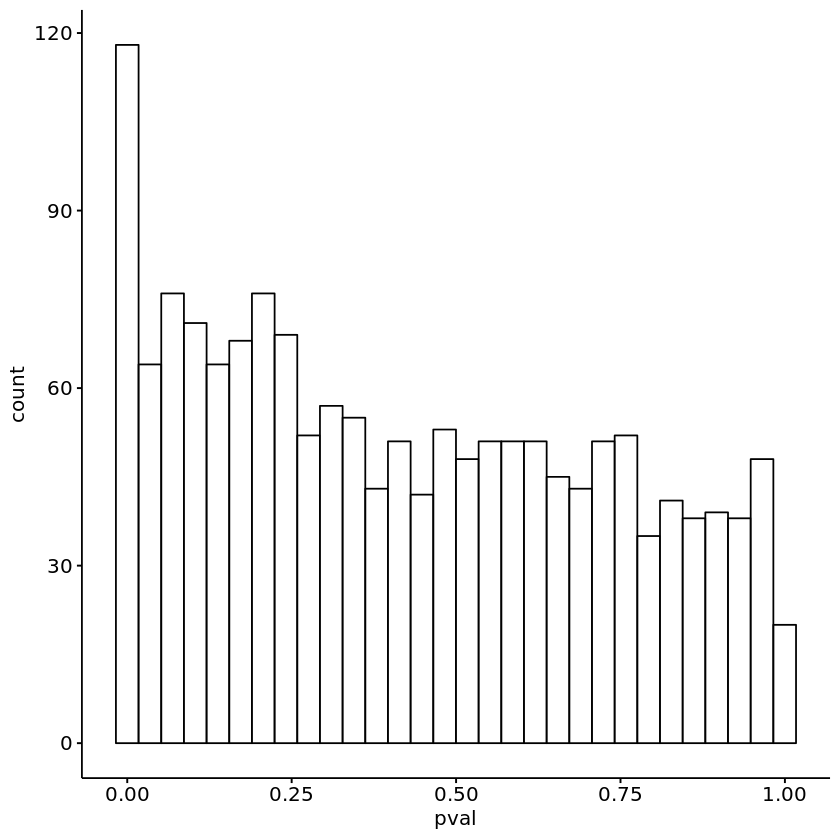

In [22]:
gghistogram(data, x = "pval")

In [23]:
data$FDR <- p.adjust(data$pval, method = "BH")
head(data)

,protein,logFC,pval,FDR
,<fct>,<dbl>,<dbl>,<dbl>
C9J600,C9J600,-0.13197723,1.320371e-01,0.606980495
A0A024RBD0,A0A024RBD0,6.58495933,1.479024e-05,0.001488268
A0A024RDB0,A0A024RDB0,-0.07009899,1.901075e-01,0.655400731
A0JNW5,A0JNW5,0.03951361,7.400306e-01,0.915316280
A0MZ66,A0MZ66,0.07251185,1.426198e-01,0.623961683
A1L0T0,A1L0T0,9.24744394,1.297691e-04,0.003541157


# (5) functional analysis

One basic approach in functional analysis of protein expression is **enrichment analysis**. Based on a **hypergeometric test** we can assess wether the occurrence of a dysregulated protein within a pre-specified **subset** (e.g. pathway) is greater than expected by chance. Details see [Picart-Armada *et.al.*;2017](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0189012)

## (5.1) selection of significantly dysregulated features 

In [25]:
features <- data %>% filter(abs(logFC)>1,FDR<=0.10) %>% dplyr::select(protein)
nrow(features)
head(features)

write.csv(data, file = "FC_pval_table.csv", row.names = FALSE)
write.csv(features, file = "features.csv", row.names = FALSE)

[1] 73

protein
<fct>
A0A024RBD0
A1L0T0
A3KMH1
A4D1E9
C9K0K2
A8CG34


## (5.2) overrepresentation analysis of Reactome pathways

In [26]:
# Biological Id TranslatoR
feature.ids = bitr(features$protein, fromType="UNIPROT", toType="ENTREZID", OrgDb="org.Hs.eg.db")
head(feature.ids)



'select()' returned 1:1 mapping between keys and columns
Warning message in bitr(features$protein, fromType = "UNIPROT", toType = "ENTREZID", :
“24.66% of input gene IDs are fail to map...”

,UNIPROT,ENTREZID
,<chr>,<chr>
1,A0A024RBD0,11163
2,A1L0T0,10994
3,A3KMH1,23078
4,A4D1E9,85865
7,A8K0Z3,100287171
8,V9HW92,9124


In [27]:
enrich.res <- enrichPathway(gene=feature.ids$ENTREZID,pvalueCutoff=0.9, qvalueCutoff = 0.9,readable=T)
head(as.data.frame(enrich.res))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-69618,R-HSA-69618,Mitotic Spindle Checkpoint,3/33,112/10654,0.004905287,0.265097,0.2391853,UBE2C/DYNC1LI2/KIF2C,3
R-HSA-72165,R-HSA-72165,mRNA Splicing - Minor Pathway,2/33,52/10654,0.011200386,0.265097,0.2391853,DDX23/SF3B5,2
R-HSA-2151201,R-HSA-2151201,Transcriptional activation of mitochondrial biogenesis,2/33,56/10654,0.012908246,0.265097,0.2391853,NCOR1/TFB1M,2
R-HSA-2467813,R-HSA-2467813,Separation of Sister Chromatids,3/33,190/10654,0.020570965,0.265097,0.2391853,UBE2C/DYNC1LI2/KIF2C,3
R-HSA-68882,R-HSA-68882,Mitotic Anaphase,3/33,201/10654,0.023823578,0.265097,0.2391853,UBE2C/DYNC1LI2/KIF2C,3
R-HSA-2555396,R-HSA-2555396,Mitotic Metaphase and Anaphase,3/33,202/10654,0.024132421,0.265097,0.2391853,UBE2C/DYNC1LI2/KIF2C,3


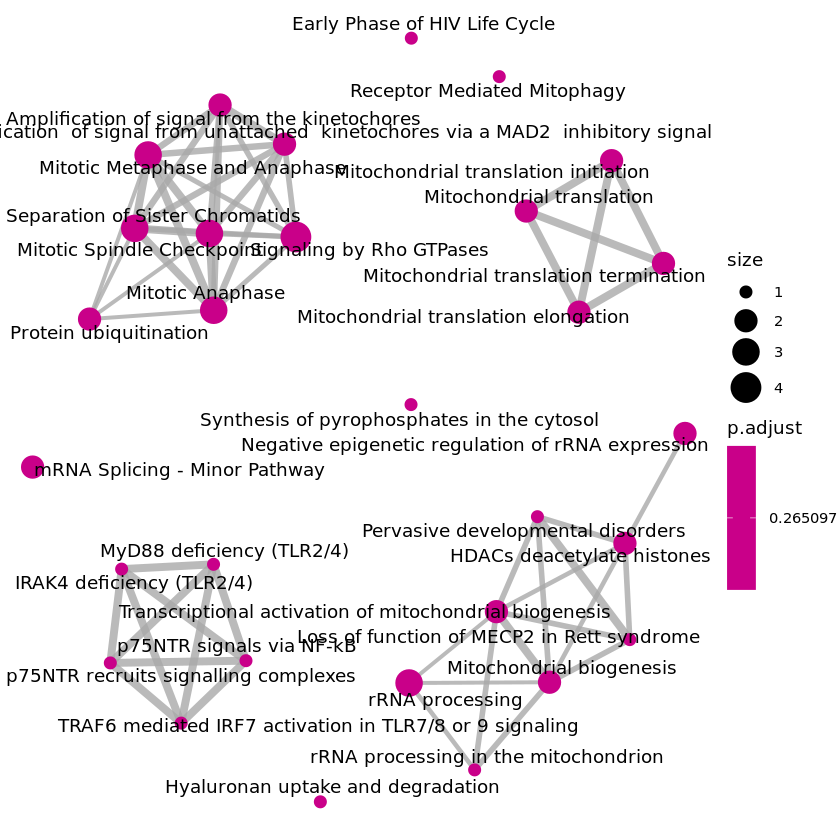

In [28]:
emapplot(enrich.res)

For more detailed analysis of enriched pathways you can load the respective info from the [**Reactome**](https://reactome.org/) online repository. The is plethora of **online tools** for functional analysis like [**DAVID**](https://david.ncifcrf.gov/) or the [**STRING**](https://string-db.org/) database. Another open enrichment and network analysis platform is offered by [**CYTOSCAPE**](https://cytoscape.org/).